# Processing and generating bacterial subset of CO-ADD database 

The database can be found [here](http://db.co-add.org/).

In [1]:
import math
import json
import pandas as pd
from tqdm import tqdm
from rdkit.Chem import MolFromSmiles, MolToInchiKey
from utils import draw_venn
import matplotlib.pyplot as plt

tqdm.pandas()
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
DATA_DIR = "../data"

In [3]:
coadd_df = pd.read_csv(
    f"{DATA_DIR}/raw/CO-ADD_DoseResponseData_r03_01-02-2020_CSV.zip",
    low_memory=False,
    on_bad_lines="skip",
    compression="zip",
)
coadd_df.head(3)

,Unnamed: 0,COADD_ID,COMPOUND_CODE,COMPOUND_NAME,SMILES,PROJECT_ID,LIBRARY_NAME,ASSAY_ID,ORGANISM,STRAIN,NASSAYS,DRVAL_TYPE,DRVAL_MEDIAN,DRVAL_UNIT,DMAX_AVE
0,0,CO-ADD:0136135,0367428:01,NaN,[H]N1C(N([H])C(OC)C(C(OC)=O)(F)C1=O)=O,CO-ADD:PL0011,NIH/NCI (USA) - Diversity Set V,MA_007,Homo sapiens,HEK293; ATCC CRL1573,2,CC50,>10,uM,4.6
1,1,CO-ADD:0136135,0367428:01,NaN,[H]N1C(N([H])C(OC)C(C(OC)=O)(F)C1=O)=O,CO-ADD:PL0011,NIH/NCI (USA) - Diversity Set V,GP_020,Staphylococcus aureus,ATCC 43300; MRSA,2,MIC,5,uM,97.9
2,2,CO-ADD:0136135,0367428:01,NaN,[H]N1C(N([H])C(OC)C(C(OC)=O)(F)C1=O)=O,CO-ADD:PL0011,NIH/NCI (USA) - Diversity Set V,GN_042,Pseudomonas aeruginosa,ATCC 27853,2,MIC,>10,uM,17.5


In [4]:
coadd_df["ORGANISM"].nunique()

17

# Subset to bacterial assays

In [5]:
bacterial_species = json.load(open(f"{DATA_DIR}/mapping/bact_mapper.json"))
len(bacterial_species)

2052

In [6]:
m1 = coadd_df["ORGANISM"].isin(bacterial_species)
m2 = coadd_df["DRVAL_TYPE"] == "MIC"
bact_coadd_df = coadd_df[m1 & m2]

In [7]:
bact_coadd_df.shape

(34995, 15)

In [8]:
cols_to_keep = [
    "COADD_ID",
    "COMPOUND_NAME",
    "SMILES",
    "ORGANISM",
    "DRVAL_TYPE",
    "DRVAL_MEDIAN",
    "DRVAL_UNIT",
]
bact_coadd_df = bact_coadd_df[cols_to_keep]

In [9]:
bact_coadd_df["bact_class"] = bact_coadd_df["ORGANISM"].map(bacterial_species)
bact_coadd_df.head()

,COADD_ID,COMPOUND_NAME,SMILES,ORGANISM,DRVAL_TYPE,DRVAL_MEDIAN,DRVAL_UNIT,bact_class
1,CO-ADD:0136135,NaN,[H]N1C(N([H])C(OC)C(C(OC)=O)(F)C1=O)=O,Staphylococcus aureus,MIC,5,uM,gram-positive
2,CO-ADD:0136135,NaN,[H]N1C(N([H])C(OC)C(C(OC)=O)(F)C1=O)=O,Pseudomonas aeruginosa,MIC,>10,uM,gram-negative
3,CO-ADD:0136135,NaN,[H]N1C(N([H])C(OC)C(C(OC)=O)(F)C1=O)=O,Acinetobacter baumannii,MIC,>10,uM,gram-negative
4,CO-ADD:0136135,NaN,[H]N1C(N([H])C(OC)C(C(OC)=O)(F)C1=O)=O,Klebsiella pneumoniae,MIC,>10,uM,gram-negative
5,CO-ADD:0136135,NaN,[H]N1C(N([H])C(OC)C(C(OC)=O)(F)C1=O)=O,Escherichia coli,MIC,>10,uM,gram-negative


In [10]:
bact_coadd_df["bact_class"].value_counts()

gram-negative    19969
fungi             9705
gram-positive     5321
Name: bact_class, dtype: int64

In [11]:
bact_coadd_df["ORGANISM"].nunique()

16

# Overlap across categories

In [12]:
compound_idx_dict = {}

for coadd_id, class_name in tqdm(bact_coadd_df[["COADD_ID", "bact_class"]].values):
    if class_name not in compound_idx_dict:
        compound_idx_dict[class_name] = set()

    compound_idx_dict[class_name].add(coadd_id)

100%|██████████| 34995/34995 [00:00<00:00, 1820952.14it/s]


In [13]:
total_compounds = set()
for i in compound_idx_dict:
    print(i, len(compound_idx_dict[i]))
    total_compounds.update(compound_idx_dict[i])

print(f"Total compounds: {len(total_compounds)}")

gram-positive 4580
gram-negative 4775
fungi 4579
Total compounds: 4781


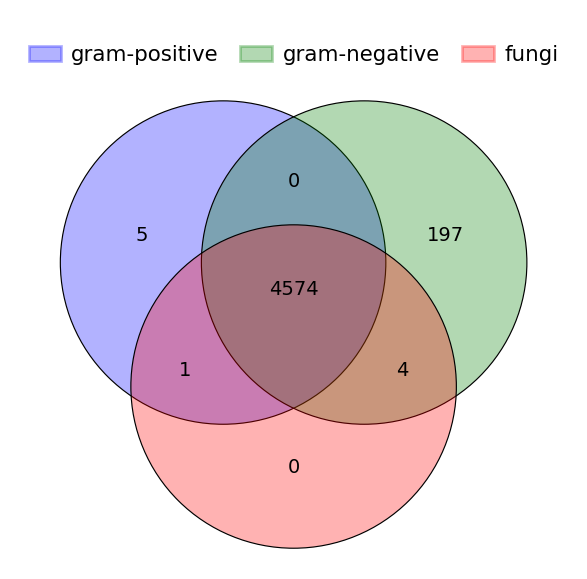

In [14]:
draw_venn(sets=compound_idx_dict)

# Normalizing to pMIC values

In [15]:
def calculate_pmic(row):
    activity = row["DRVAL_MEDIAN"]
    if "=" in activity:
        activity = activity.split("=")[1]
    elif ">" in activity:
        activity = activity.split(">")[1]
    elif "<" in activity:
        activity = 0

    if activity == 0.0:
        return 0
    elif row["DRVAL_UNIT"] == "nM" and pd.notna(activity):
        return round(9 - math.log10(float(activity)))
    elif row["DRVAL_UNIT"] == "uM" and pd.notna(activity):
        return round(6 - math.log10(float(activity)))
    elif row["DRVAL_UNIT"] == "mM" and pd.notna(activity):
        return round(3 - math.log10(float(activity)))
    else:
        return 0


bact_coadd_df["pmic"] = bact_coadd_df.apply(calculate_pmic, axis=1)

<AxesSubplot: ylabel='Frequency'>

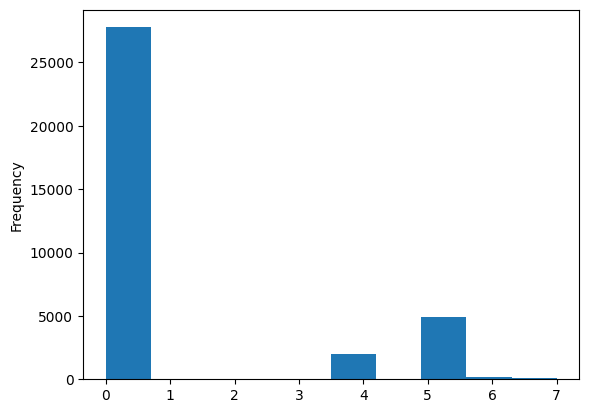

In [16]:
bact_coadd_df["pmic"].plot(kind="hist")

In [17]:
data = []

for smile in tqdm(bact_coadd_df["SMILES"].unique()):
    tmp = bact_coadd_df[bact_coadd_df["SMILES"] == smile]

    data_dict = {
        "compound_smiles": smile,
        "compound_source": "coadd_03_01-02-2020",
    }

    for bact_class_name in ["gram-positive", "gram-negative", "fungi", "acid-fast"]:
        t = tmp[tmp["bact_class"] == bact_class_name]
        if t.shape[0] == 0:
            data_dict[bact_class_name] = None
        elif t.shape[0] == 1:
            data_dict[bact_class_name] = t["pmic"].values[0]
        else:
            data_dict[bact_class_name] = t["pmic"].median()

    data.append(data_dict)

100%|██████████| 4763/4763 [00:06<00:00, 751.92it/s]


In [18]:
final_df = pd.DataFrame(data)
final_df.head()

,compound_smiles,compound_source,gram-positive,gram-negative,fungi,acid-fast
0,[H]N1C(N([H])C(OC)C(C(OC)=O)(F)C1=O)=O,coadd_03_01-02-2020,5.0,5.0,5.0,None
1,c1cc(C)c(N2C=NC(NC)=NC2=O)c(C)c1,coadd_03_01-02-2020,5.0,5.0,5.0,None
2,c1c(c(cc(Cl)c1)sc2S[H])n2,coadd_03_01-02-2020,5.0,5.0,5.0,None
3,O=C(C(C(=O)c(cccc1)c1)C(O2)=O)C=C2c(cccc3)c3,coadd_03_01-02-2020,5.0,5.0,5.0,None
4,n1ccc2c(c1)c(C)c(c3c(cccc3)n4[H])c4c2C,coadd_03_01-02-2020,5.0,5.0,5.0,None


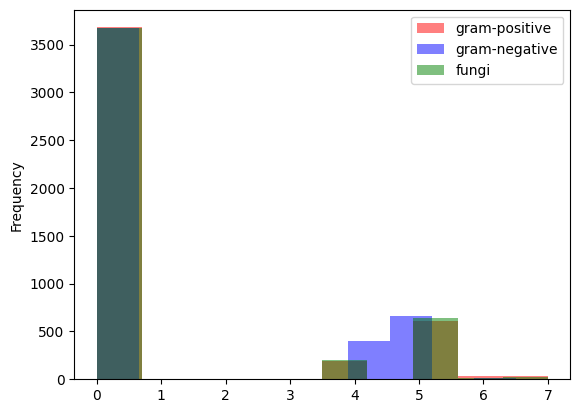

In [19]:
fig, ax = plt.subplots(1, 1)
final_df["gram-positive"].plot(kind="hist", ax=ax, alpha=0.5, color="red")
final_df["gram-negative"].plot(kind="hist", ax=ax, alpha=0.5, color="blue")
final_df["fungi"].plot(kind="hist", ax=ax, alpha=0.5, color="green")
plt.legend()
plt.show()

In [20]:
# Adding in inchikey to be consistent with other datasets
def get_inchikey(smiles):
    mol = MolFromSmiles(smiles)
    if mol:
        return MolToInchiKey(mol)
    return None


final_df["compound_inchikey"] = final_df["compound_smiles"].progress_apply(get_inchikey)

100%|██████████| 4763/4763 [00:01<00:00, 3801.57it/s]


In [21]:
final_df.to_csv(f"{DATA_DIR}/processed/bacterial_coadd.tsv", sep="\t", index=False)